# CS 497/597: Tensorflow With Mobilenet V2

## Purpose of the assignment:

To familiarize ourselves with Tensorflow and MobileNet V2 by training, tuning, and explaining how MobileNet V2 works by training it on both CIFAR100 and a dataset of our choosing. 

### Step 1: Data Preprocessing

In [2]:
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
import os

In [5]:
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [6]:
# Import the training and test data for CIFAR100 and load 
# the fine grained class labels so we can use all 100 classes

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data(label_mode='fine')

In [7]:
# Print the shape of the training and testing images and labels
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


Note: CIFAR100 contains 60,000 images total with 100 classes. Each image is size 32 x 32 with RGB values for a total of 32 x 32 x 3 size per image. This means that each image is somewhat small in size, with only 1024 pixels and 3072 values total including RGB pixel values. The dataset loaded here is split into 50K training images and 10K test images (80% training and 20% testing).

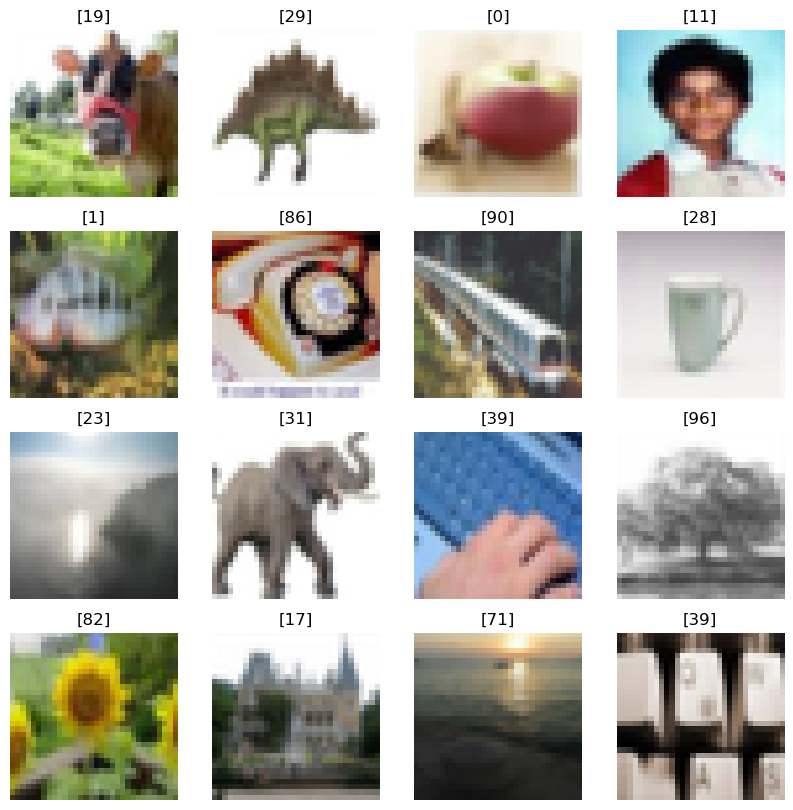

In [8]:
# Show 16 example images from the CIFAR100 dataset
plt.figure(figsize=(10,10))

for i in range(16):
    ax = plt.subplot(4,4, i+1)
    plt.imshow(x_train[i])
    plt.title(y_train[i])
    plt.axis("off")

Looking at the first 16 images in the training dataset, it is clear that 1024 pixels doesn't leave room for a lot of detail. Most of the images are blurry with little space for even large patterns. The image at the bottom right appears to be a keyboard, but the image is so small that it is impossible to read what keys are displayed in the image. The image in the bottom left is an image with 3 sunflowers, but it is so pixelated that it is difficult to see how many flower petals each sunflower has. This lack of detail could either help a CNN focus on key features of an image or hurt a CNN by blurring important features that can help it distinguish between classes. We cannot know for sure whether this improves or harms MobileNet's performance until it is tested. 

In [9]:
# Split the test dataset into testing and validation datasets for tuning and testing MobileNetVs2

division_point = int(x_test.shape[0]/2)
x_validation, y_validation = x_test[0:division_point], y_test[0:division_point]
X_test, Y_test = x_test[division_point:x_test.shape[0]], y_test[division_point:x_test.shape[0]]

In [31]:
# Run data augmentation to randomize incoming images and prevent overfitting with ImageNet
data_augmentation = keras.Sequential([
  keras.layers.RandomFlip('horizontal'),
  keras.layers.RandomRotation(0.2),
])

### Step 2: Model Construction

In [12]:
# Download and construct a base MobileNet V2 model on top of ImageNet weights
base_mobilenet = tf.keras.applications.MobileNetV2(input_shape=x_train[0].shape, include_top=False)

/tmp/ipykernel_40897/1522465229.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_mobilenet = tf.keras.applications.MobileNetV2(input_shape=x_train[0].shape, include_top=False)
I0000 00:00:1726033020.452253   40897 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1726033020.452497   40897 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1726033020.452677   40897 cuda_executor.cc:1015] successful NUMA node read from S

In [38]:
# Show the structure of MobileNet V2 without any classification head added
base_mobilenet.summary()

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 16, 16,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 16, 16,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 16, 16,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 16, 16,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 16, 16,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 16, 16,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 16, 16,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 16, 16,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 16, 16,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 16, 16,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 16, 16,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 17, 17,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 8, 8, 96)  │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 8, 8, 96)  │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 8, 8, 96)  │          0 │ block_1_depthwis… │
│ (ReLU)              │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 8, 8, 24)  │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,223,872 (8.48 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [58]:
# Create a small batch from the training dataset for simple testing
training_dataset = tf.data.Dataset.from_tensor_slices((x_train, keras.utils.to_categorical(y_train))).batch(batch_size=32)
image_batch, label_batch = next(iter(training_dataset))
print(image_batch.shape)
feature_batch = base_mobilenet(image_batch)
print(feature_batch.shape)

(32, 32, 32, 3)
(32, 1, 1, 1280)


In [59]:
# Create the validation and testing datasets

validation_dataset = tf.data.Dataset.from_tensor_slices((x_validation, keras.utils.to_categorical(y_validation))).batch(batch_size=32)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, keras.utils.to_categorical(Y_test))).batch(batch_size=32)

In [60]:
# Set up the prediction head for MobileNetV2 for CIFAR100

# Create a global pooling layer for the output RELU functions
global_average_layer = keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)

# Create a prediction layer for each class in the CIFAR100 dataset
prediction_layer = keras.layers.Dense(100, activation='sigmoid')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 100)


In [61]:
# Create the entire model and pipeline with all data preprocessing and output layers
# as well as MobileNetV2

# Create an input layer for the image itself
input = tf.keras.Input(shape=x_train[0].shape)
# Apply data augmentation pipeline
x = data_augmentation(input)
# Run the augmented image through MobileNet and train it
x = base_mobilenet(x, training=True)
# Average the output of all RELU functions for the fully connected layer
x = global_average_layer(x)
# apply dropout to prevent overfitting
x = keras.layers.Dropout(0.2)(x)
# Get the final prediction of the model with a single fully connected layer
output = prediction_layer(x)
# Construct the model and pipeline
model = keras.Model(input, output)

In [63]:
#3 Show the fully constructed model's parameter count and memory footprint including the base MobileNet V2 model
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 1, 1, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_8      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 100)            │       128,100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,386,084 (9.10 MB)

 Trainable params: 2,351,972 (8.97 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [64]:
# Set the learning rate, optimizer, loss function, and evaluation metrics for the model
base_learning_rate = 0.0001
model.compile(optimizer=keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=keras.losses.CategoricalCrossentropy(),
              metrics=[keras.metrics.Accuracy(name="accuracy")])

In [65]:
# Train MobileNet for 10 epochs total
total_epochs = 10
model.fit(training_dataset, epochs=total_epochs, validation_data=validation_dataset)

Epoch 1/10


W0000 00:00:1726035329.605961   41640 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726035329.609523   41640 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726035329.609837   41640 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726035329.633671   41640 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726035329.634043   41640 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726035329.634353   41640 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726035329.634658   41640 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726035329.634961   41640 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726035329.635286   41640 gp

   1/1563 ━━━━━━━━━━━━━━━━━━━━ 6:28:21 15s/step - accuracy: 0.0000e+00 - loss: 5.7366

W0000 00:00:1726035330.793996   41639 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726035330.794287   41639 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726035330.794579   41639 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726035330.794867   41639 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726035330.795167   41639 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726035330.795462   41639 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726035330.795758   41639 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726035330.796068   41639 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726035330.796366   41639 gp

1562/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.0000e+00 - loss: 4.9771

W0000 00:00:1726035399.266308   41638 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726035399.266704   41638 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726035399.267019   41638 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726035399.267353   41638 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726035399.267696   41638 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726035399.268028   41638 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726035399.268366   41638 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726035399.268696   41638 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726035399.269016   41638 gp

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.0000e+00 - loss: 4.9768

W0000 00:00:1726035400.071749   41638 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726035400.072036   41638 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726035400.076975   41638 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726035400.077370   41638 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726035400.077664   41638 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726035400.077961   41638 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726035400.078274   41638 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726035400.078564   41638 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726035400.078882   41638 gp

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 85s 45ms/step - accuracy: 0.0000e+00 - loss: 4.9765 - val_accuracy: 0.0000e+00 - val_loss: 4.3424
Epoch 2/10
   3/1563 ━━━━━━━━━━━━━━━━━━━━ 1:14 48ms/step - accuracy: 0.0000e+00 - loss: 4.0694

W0000 00:00:1726035401.500654   41633 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726035401.501090   41633 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726035401.501435   41633 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726035401.501771   41633 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726035401.502110   41633 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726035401.502441   41633 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726035401.502774   41633 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726035401.503144   41633 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726035401.503512   41633 gp

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 68s 43ms/step - accuracy: 0.0000e+00 - loss: 3.9825 - val_accuracy: 0.0000e+00 - val_loss: 3.7440
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 69s 44ms/step - accuracy: 0.0000e+00 - loss: 3.5525 - val_accuracy: 0.0000e+00 - val_loss: 3.2091
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 72s 46ms/step - accuracy: 0.0000e+00 - loss: 3.2883 - val_accuracy: 0.0000e+00 - val_loss: 3.0896
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 67s 43ms/step - accuracy: 0.0000e+00 - loss: 3.0705 - val_accuracy: 0.0000e+00 - val_loss: 2.7876
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 64s 41ms/step - accuracy: 0.0000e+00 - loss: 2.8813 - val_accuracy: 0.0000e+00 - val_loss: 2.6959
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 70s 45ms/step - accuracy: 0.0000e+00 - loss: 2.7504 - val_accuracy: 0.0000e+00 - val_loss: 2.5608
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 71s 45ms/step - accuracy: 0.0000e+00 - loss: 2.6078 - val_accuracy: 0.0000e+00 - val_loss: 2.4541
Epoch 9/10
1563/1563 ━━━━━━━━━━

In [68]:
model.save_weights(filepath="checkpoints/train/MobileNetV2_CIFAR100.weights.h5", overwrite=True)